## Entrainment of Gamma waves - and why

We have discussed the 'glimphatic system' in a lecture, the system which apparently is responsible for 'housecleaning'
in the human brain and is mostly active during sleep, particularly deep sleep.  The system clears and removes waste
products, eg. Amyloid plaque, which is observed in patients with Alzheimer's disease, where its accumulation may have 
caused the death of neurons.

Studies at MIT and elsewhere have shown that by stimulating the glimphatic system in mouse brains can produce dramatic
reduction of amyloid plaque, with just a short session - one famous example cited 50% plaque reduction after an hour's 
session of stimulation.  

Stimulation was first made with optogenetically modified brain tissue, and the brains were directly exposed to flashing 
lights (having opened the skulls).  The lights flashed at 40 Hz, an apparent housecleaning frequency of Gamma waves.
Later experiments exposed the unmodified, un-opened mice to flashing lights via the normal eye route, and this was found
to work just as well.

At that point I thought: _why not use sound waves, play a 40 Hz sound for a person?_  I was thinking of the recordings I
have heard of Tibetan monks humming away at low frequencies.  I've subsequntly seen work by others that shows people are
experimenting with this, either direct 40 Hz sound, or 'binaural' sound of two channels, one in each ear, with an arti-
ficial frequency shift that causes a 40 Hz 'beat' to be experienced by the listener.  

I wanted to see if I could **induce or amplify gamma waves at 40 Hz in my own brain**, with simple methods, hence this
experiment and recording.  I recorded EEG from myself, only a handful of channels to start with, while I listened to a 
40-Hz sound produced by a small loudspeaker some 2-3 metres away -an iPhone with a sound generation App set to 40 Hz 
square wave. The App used is Thomas Gruber's "Function Generator", available for free.

There are **three separate periods** in this recording:

1. rest in silence for about 7 minutes
2. rest while sound is played, for about nine minutes
3. rest in silence for about 6 minutes

The EEG was recorded at 1000 Hz, on seven channels:  ['C3', 'C4', 'P3', 'P4', 'Fz', 'Cz', 'Pz']  
These channel names follow a standard naming convention, and standard locations on the skull. 


# Note

This notebook will **not work without the MNE library**, which must be present in the python/notebook environment.
As needed, eiher execute a

**!pip install mne**

or similar, appropriate to your environment, or install it before executing the notebook.


In [1]:
import os.path as op
import numpy as np

import mne
from mne.channels import compute_native_head_t, read_custom_montage
from mne.viz import plot_alignment

import scipy
from scipy.signal import welch, blackman, stft
from scipy.fft import fft,rfft

import matplotlib
import matplotlib.pyplot as plt


In [2]:
## You may need this setting here for some of the plots
## don't activate unless you know that you need it.
##
mne.viz.set_browser_backend( 'matplotlib')

Using matplotlib as 2D backend.


In [3]:
#@title Figure Settings
import ipywidgets as widgets #interactive display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#-----

# Get Raw data. 

The whole session lasted less than 1500 seconds (or < 25 minutes).

Sampling frequency was 1000;

The Bittium Tesla amplifiers and NeurOne control equipment produces the output data 
in three separate files, in accordance with the "**BrainVision**" de-facto standard.

This system uses **three files**, 
1. a header file: (filename).vhdr
2. a "marker file", with time markers (if needed): (filename).vmrk
3. the raw recorded data, each time point x all channels at that time, in a 24-bit notation: (filename).eeg


The mne interface knows how to deal with the three files. It only needs the header file name.

**Note:** the header and marker files contain the names of the eeg file as text, so if you want to rename the
datafiles, you need to edit these two files accordingly  It is easy, they are simple text files.


In [4]:
## without the ', preload=True' part, the system only loads a small portion of the data into memory.
## This data is small, I can afford to load the whole mess at once.
##
raw = mne.io.read_raw_brainvision( "GammaTE.vhdr", preload=True)

Extracting parameters from GammaTE.vhdr...
Setting channel info structure...
Reading 0 ... 1409319  =      0.000 ...  1409.319 secs...



To ensure the load went as expected, do a couple of sanity checks, using standard MNE data structure methods:

In [6]:

raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: C3, C4, P3, P4, Fz, Cz, Pz
 chs: 7 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 1000.0 Hz
>

In [7]:
raw.ch_names

['C3', 'C4', 'P3', 'P4', 'Fz', 'Cz', 'Pz']


There are no Stimuli or other Markers in this data.  Just a single, raw recording.

It is often done to calculate an 'average' of all the channels, and use that as a 
base from which to reference all the channels.  This removes some environmental 
biases, if they exist.


In [4]:
# Since there are only a few channels and I only need the PSD, it isn't really
# worth doing these averages, but for consistency's sake
#
# Apply Projection: Average EEG reference:

raw.set_eeg_reference(ref_channels='average', projection=True ) # added as projection, not applied to data ...
_ = raw.apply_proj()                                            # ... applied to data

EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


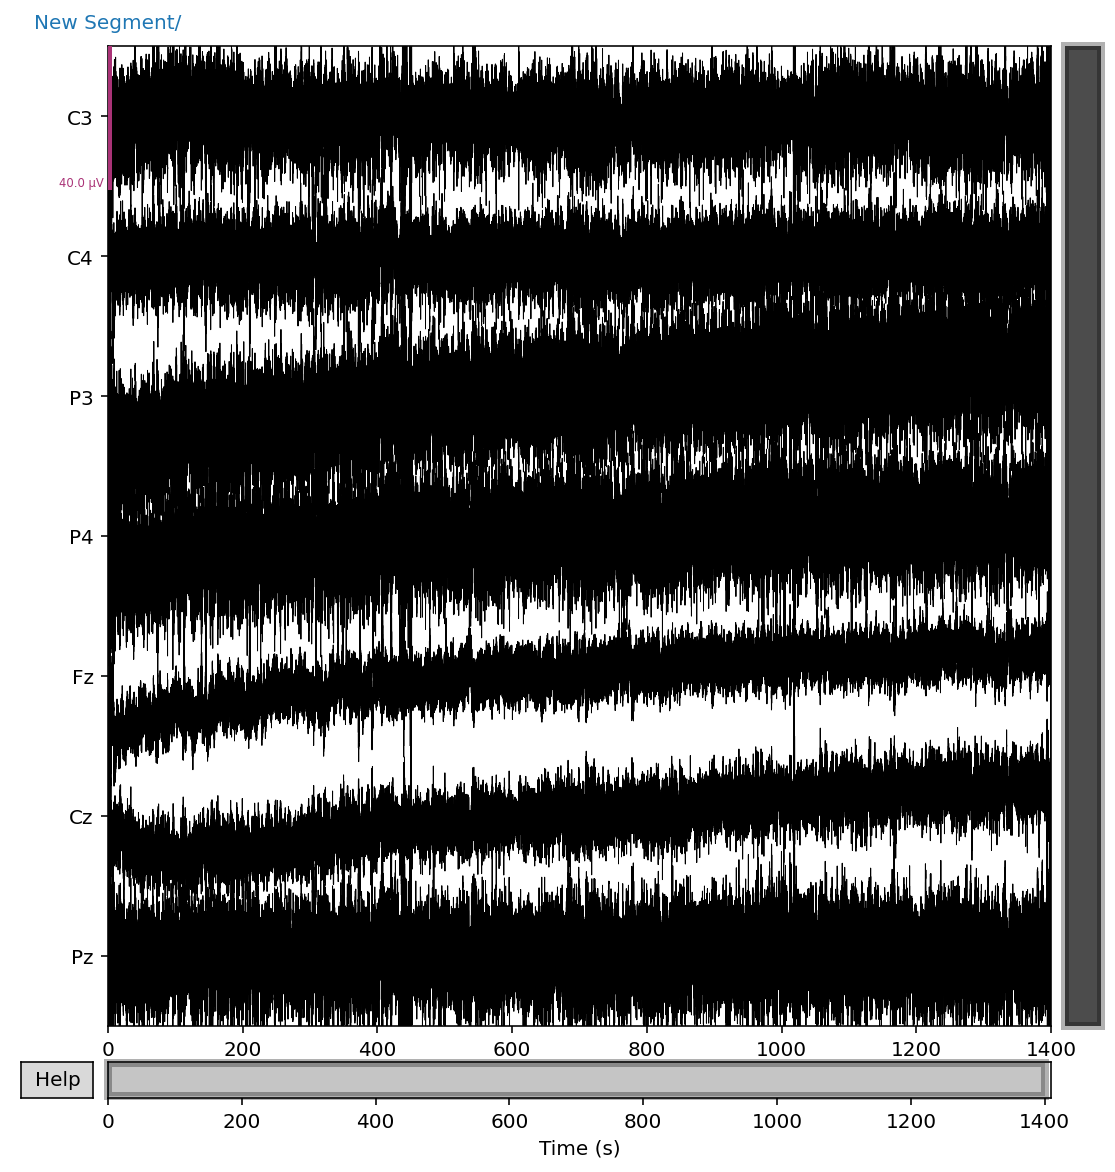

In [5]:
# coarse overview:
#
_ = raw.plot(duration=1400)

Clearly, and as expected, there are three separate periods in the file:
(this is evident from the vertical lines at around 420 and around 1000 or so)

1. about seven minutes (= 420 secs )  of "Before"
2. about nine minutes (= 540 secs) of "during audio signal"
3. about six minutes (= 360 secs) of "after" 

This makes around 1320 secs in total, leaving 89 seconds in total unaccounted for 
by imprecision, as we have recorded 1409 seconds worth of data.

From the plot above, we see that it is best to skip an interval around 420 Sec and 
again around 1000 secs.  Those correspond to the time I had to move to switch the 
sound generator on/off.  Also, at the very ends (both ends), there is disturbance
due to movement.  This was expected. 
  

# Plotting electrode locations

I'd like to do a location plot of the channels, and for that I obviously need to specify
the actual coordinates of the electrode locations. This standard file defines a full set
of electrodes, which we don't need here, as I am only using six electrodes, all more or less at the top of the head.

The definitions are given in terms of two angles, from a vertical axis through the top of the head, and a horizontal one
between the Inion and Nasion points on the skull.  


In [6]:
# To be able to do plot with channel locations, I'll obviously need locations.  
# In this case, all the channels recorded are on the top of the head, 
# so this is somehat moot, but anyway:
#
dig_montage = read_custom_montage('BC-TMS-128.bvef', head_size=None, coord_frame='mri')
_ = raw.set_montage(dig_montage)

/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/1816778085.py:6: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  _ = raw.set_montage(dig_montage)


# Frequencies 

Here, we get to the meat of the matter, the frequencies of the recorded signals.

I'd like to see the frequencies present before I apply the 40 Hz sound, then during the sound, and finally after the sound is turned off.
These are standard PSD (Power Spectra) plots which have been limited to the frequency range 4 - 48 Herz only.  The Gamma wave applied by
sound, again, is 40 Hz.  I don't want to see anything under 4 Hz (movement and noise) and don't want to deal with the 50 Hz electrical
network noise, which is always present, so I cut off at 48 Hz .

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/2101361558.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/2101361558.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


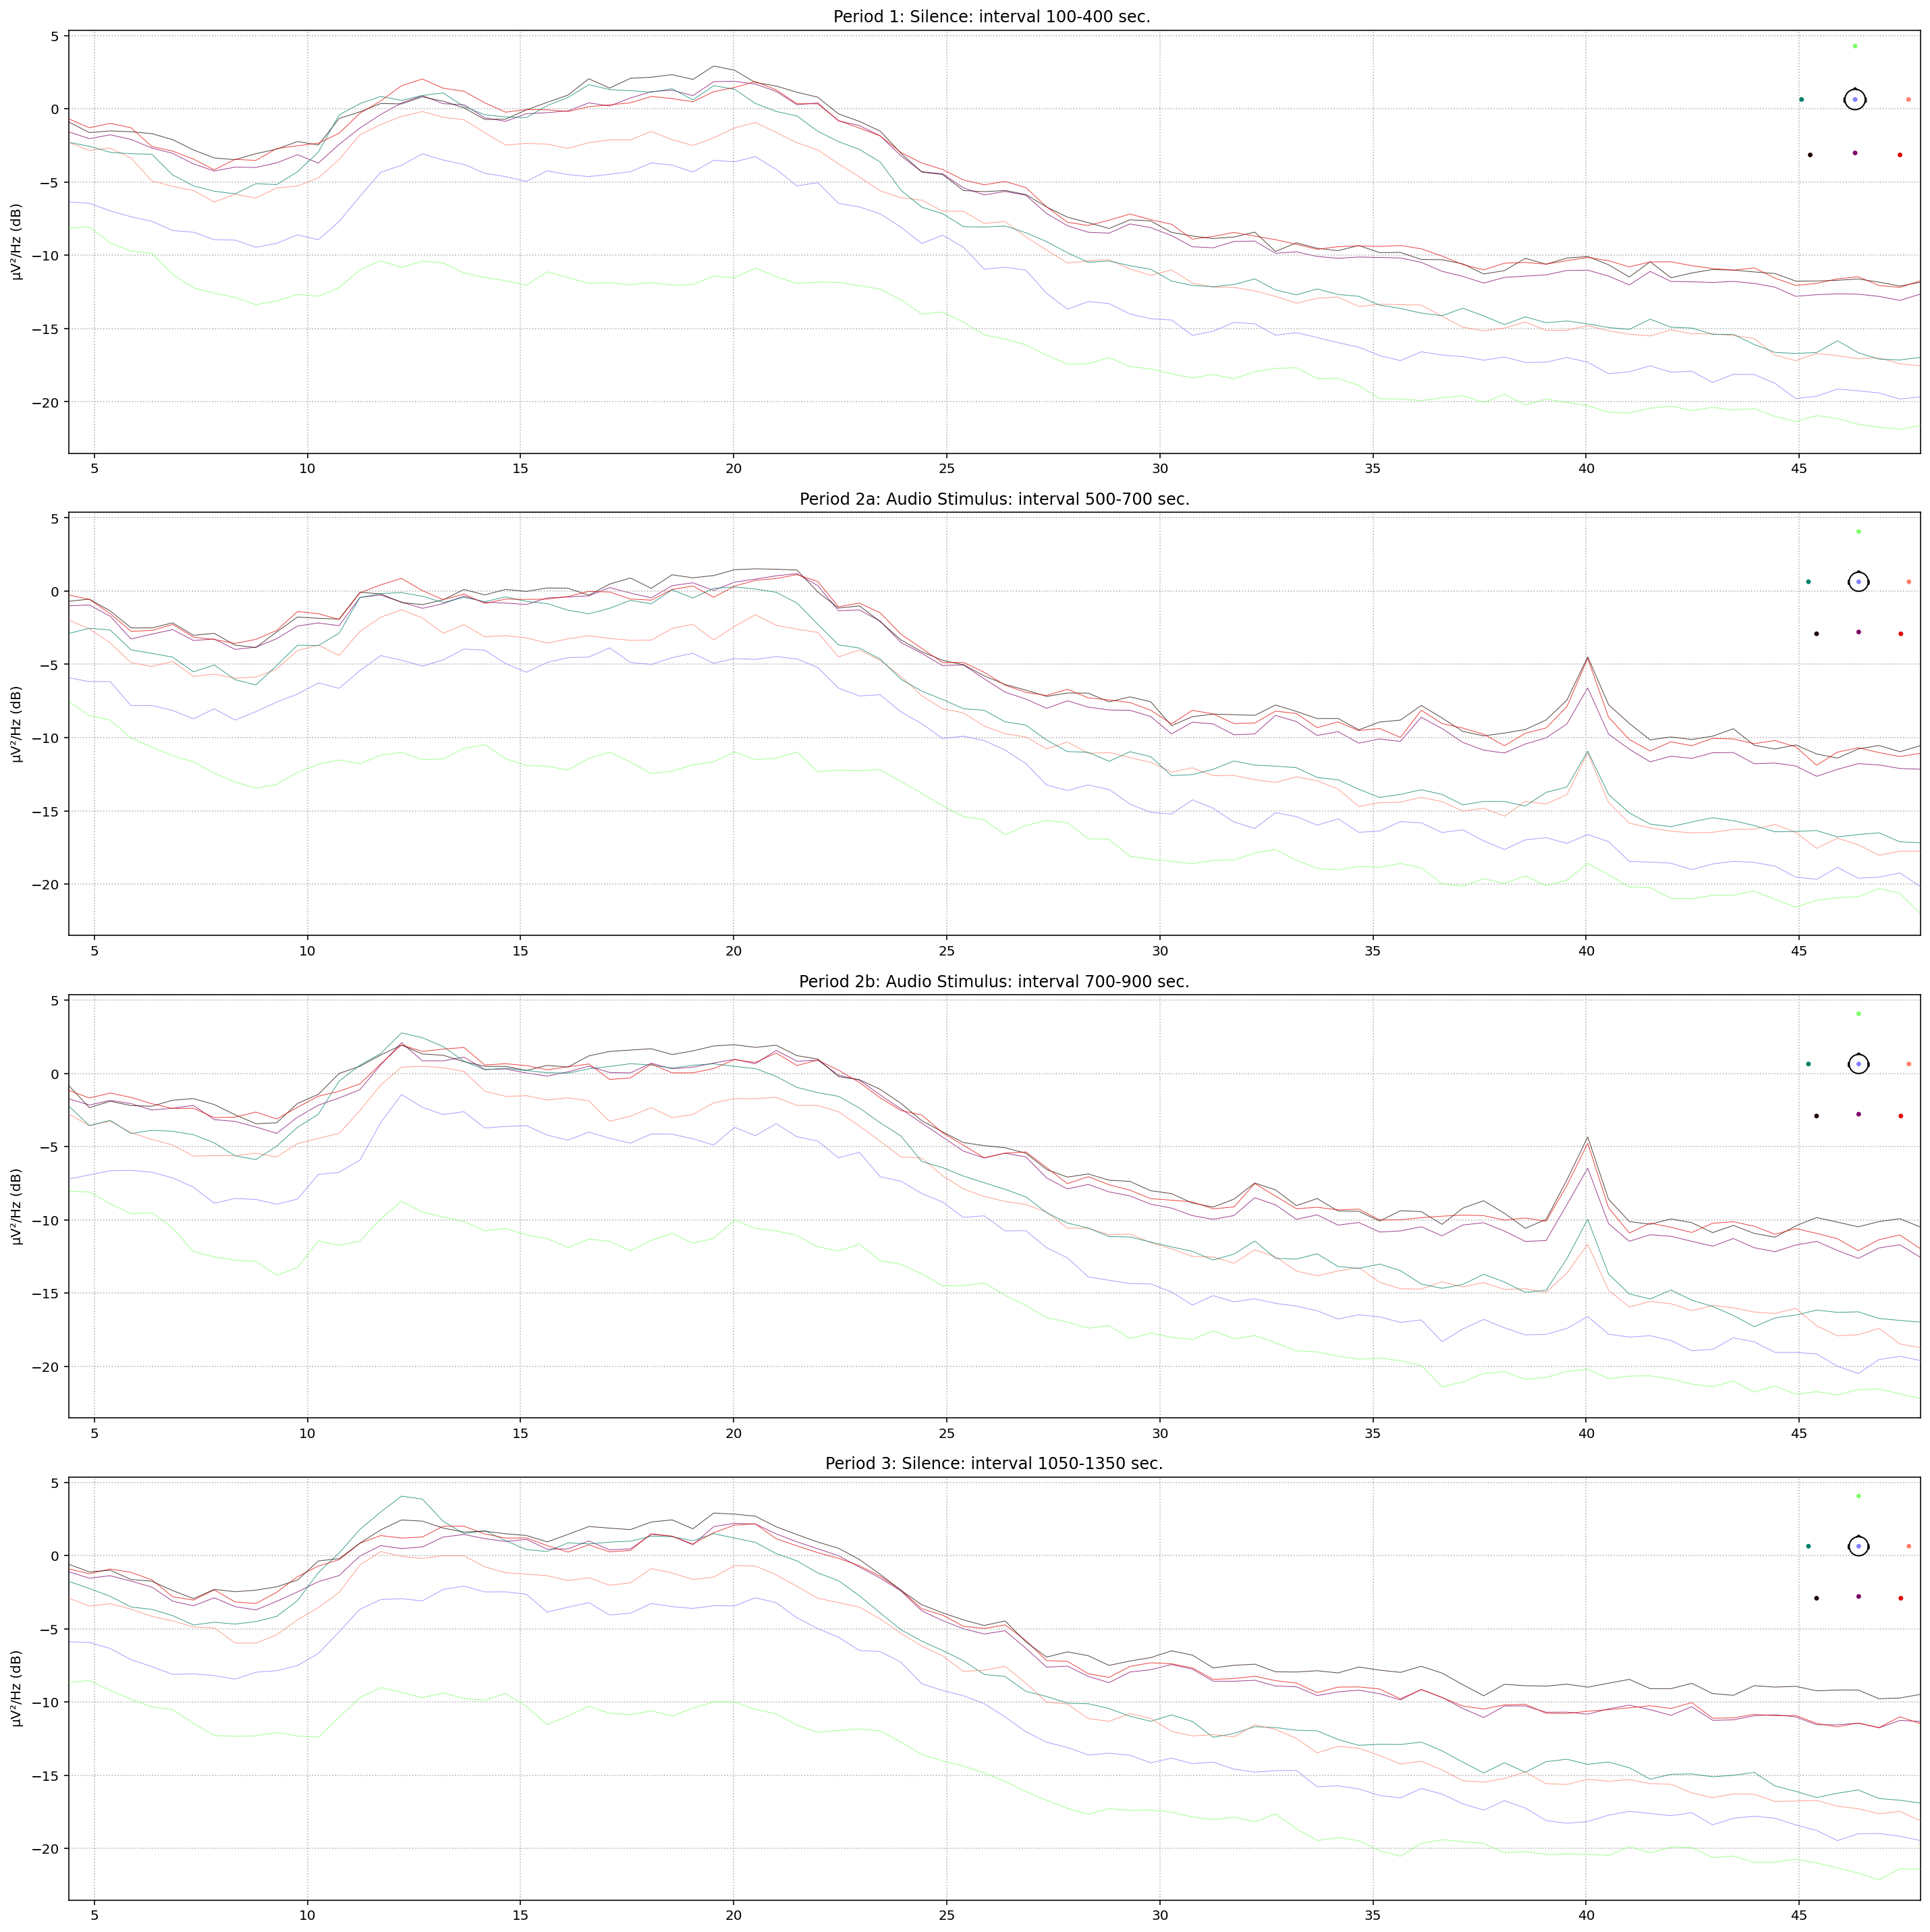

In [7]:
# Plot the PSDs of this data :
# I am interested in the low frequencies, between 4 and 48 Hz. only.

fig, ax = plt.subplots(4, sharey=True)  
fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=100,tmax=400,fmin=4.0,fmax=48.0, ax=ax[0], show=False)
ax[0].set_title('Period 1: Silence: interval 100-400 sec. ')

_ = mne.viz.plot_raw_psd(raw,tmin=500,tmax=700,fmin=4.0,fmax=48.0, ax=ax[1], show=False)
ax[1].set_title('Period 2a: Audio Stimulus: interval 500-700 sec.')

_ = mne.viz.plot_raw_psd(raw,tmin=700,tmax=900,fmin=4.0,fmax=48.0, ax=ax[2], show=False)
ax[2].set_title('Period 2b: Audio Stimulus: interval 700-900 sec.')

_ = mne.viz.plot_raw_psd(raw,tmin=1050,tmax=1350,fmin=4.0,fmax=48.0, ax=ax[3], show=False)
ax[3].set_title('Period 3: Silence: interval 1050-1350 sec.')

fig.tight_layout()  
fig.show()


# Result

We do see a bit of a bump at 40 Hz during the period when the sound was played. None before or after.
The Gamma effect died out very quickly, and the decrease period is difficult to separate from the burst 
of activity when I needed to go and turn off the sound, that caused a lot of noise in the recording.  


# Some further tests

The following frames are only some additional data tests done, that do not change (or improve on) the above result.


Effective window size : 2.048 (s)


/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3147/3839783878.py:4: RuntimeWarning: in version 1.5, the default behavior of Spectrum.plot() will change so that bad channels will be shown by default. To keep the old default behavior (and silence this warning), explicitly pass `picks='data', exclude='bads'`.
  _ = spectrum.plot(average=True, )
/Users/edwald/anaconda3/anaconda3/envs/mne38/lib/python3.8/site-packages/mne/viz/utils.py:151: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


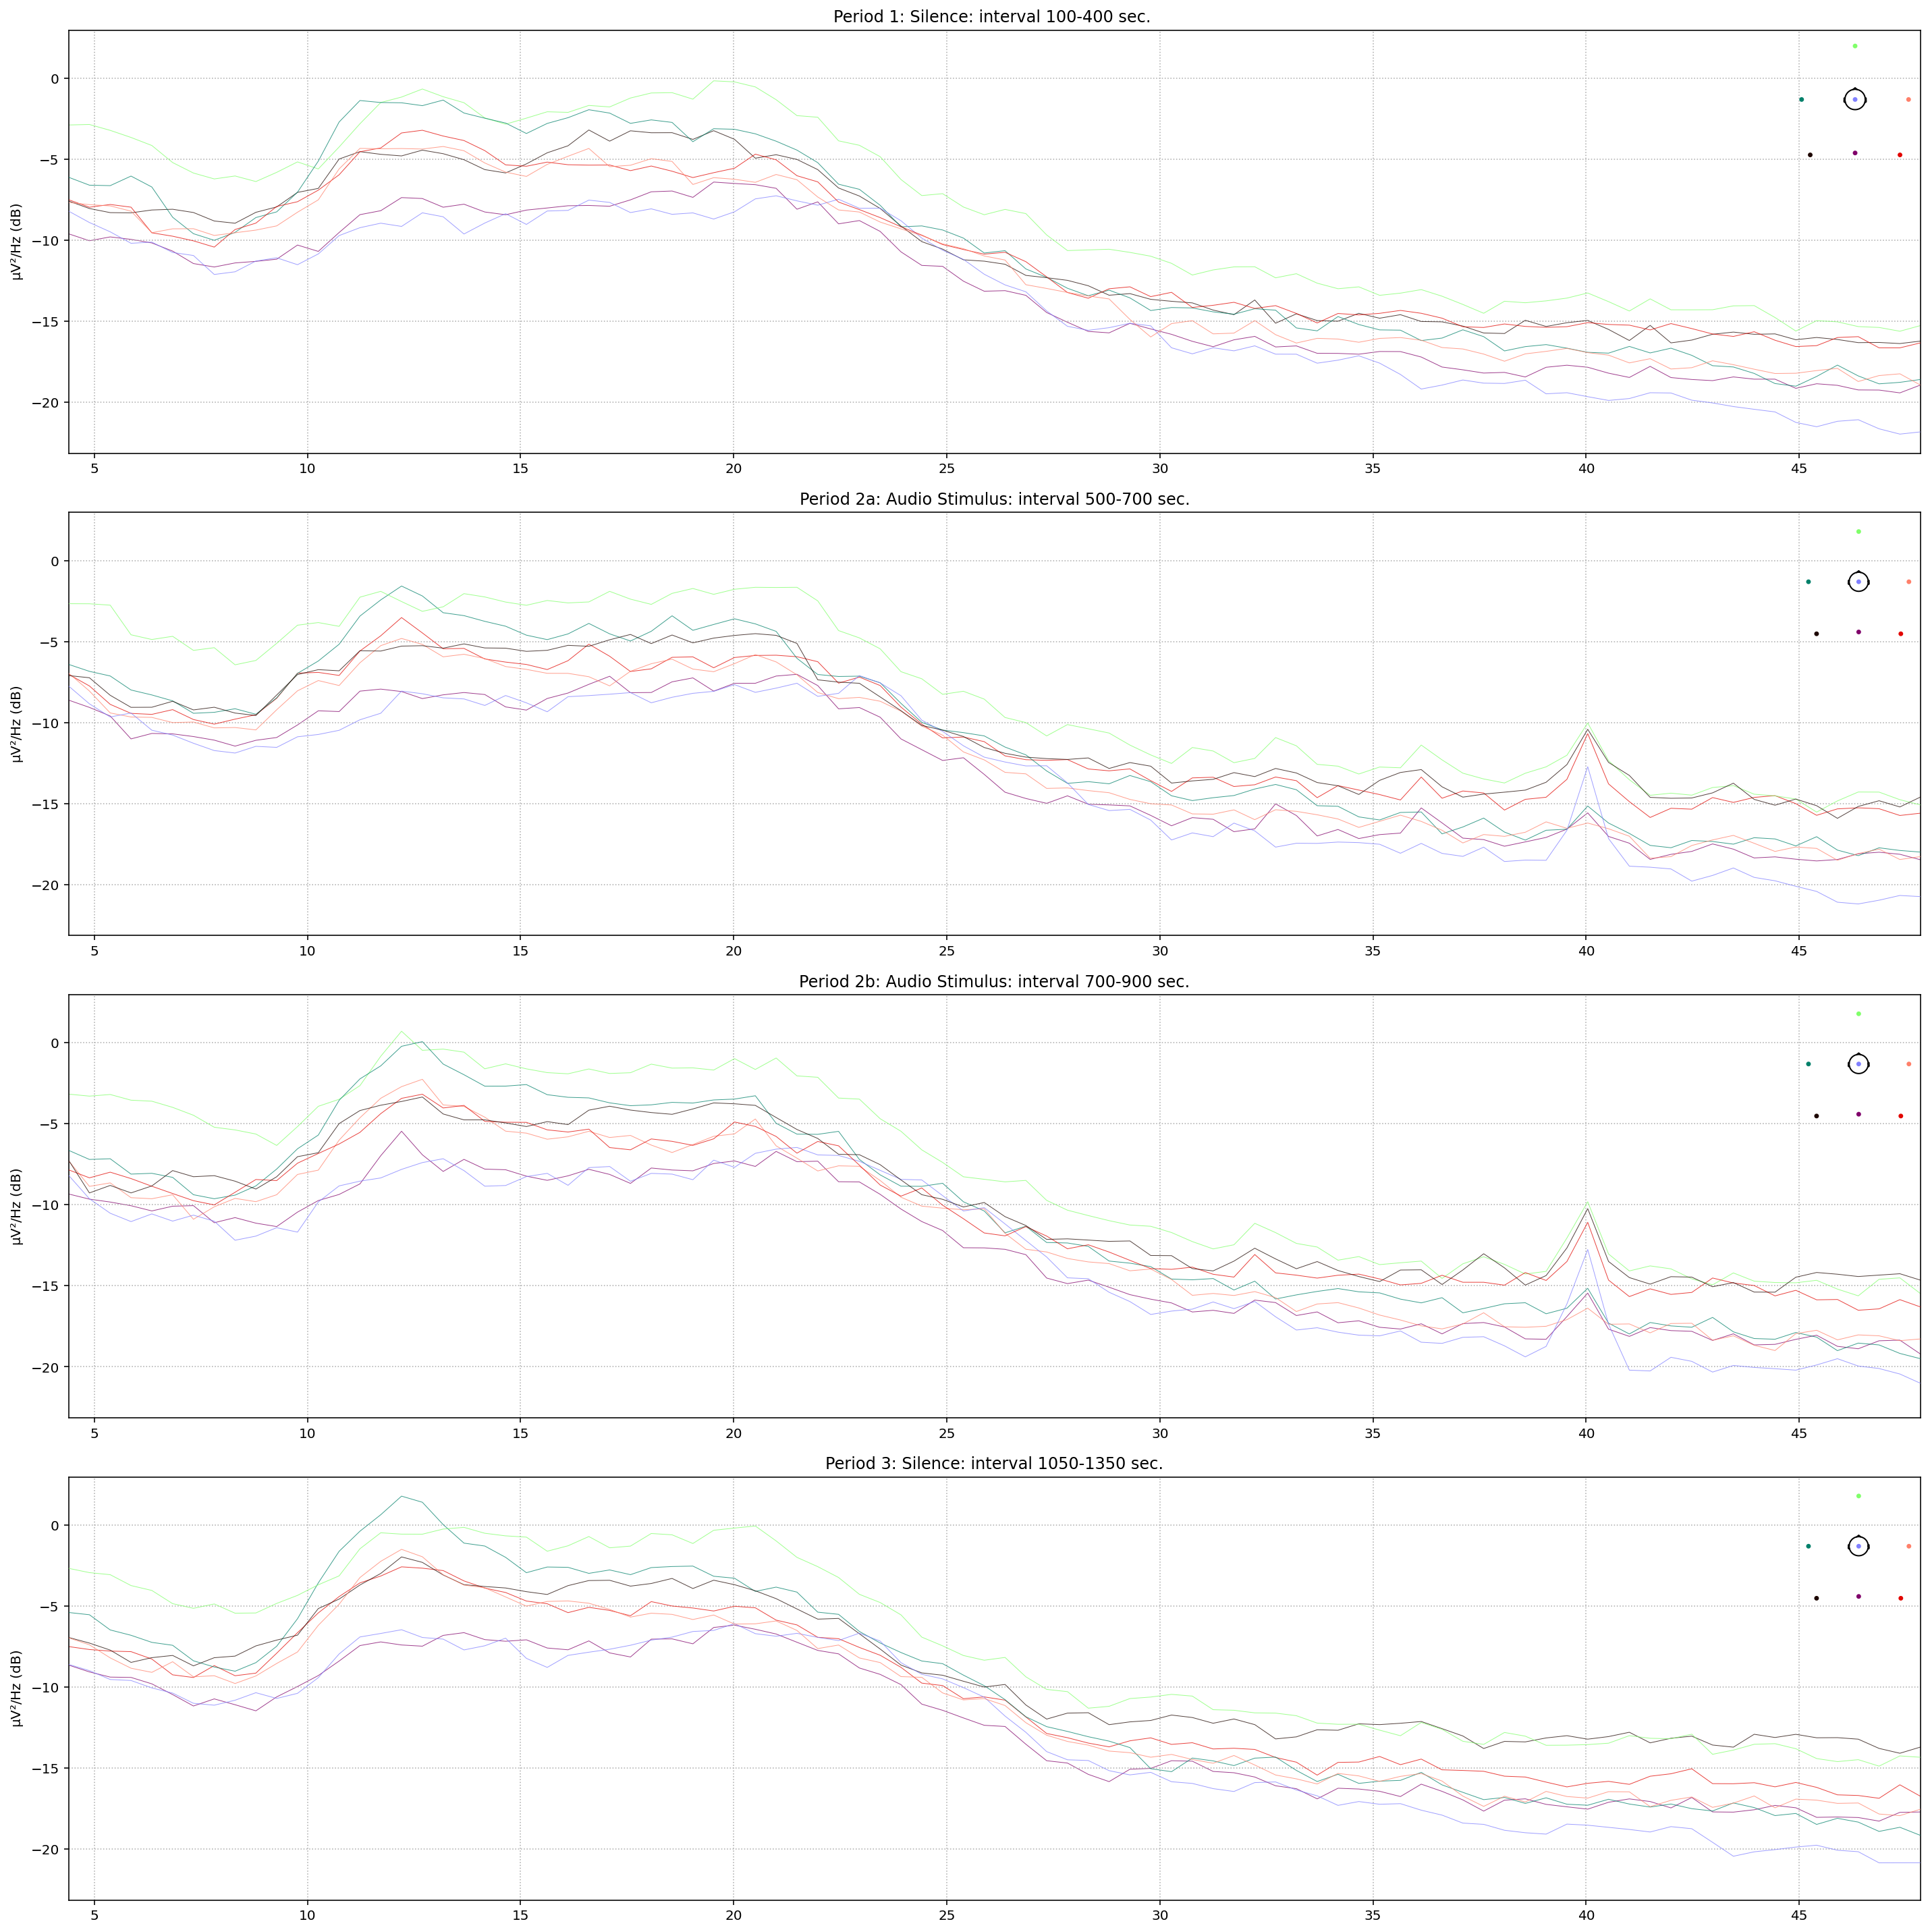

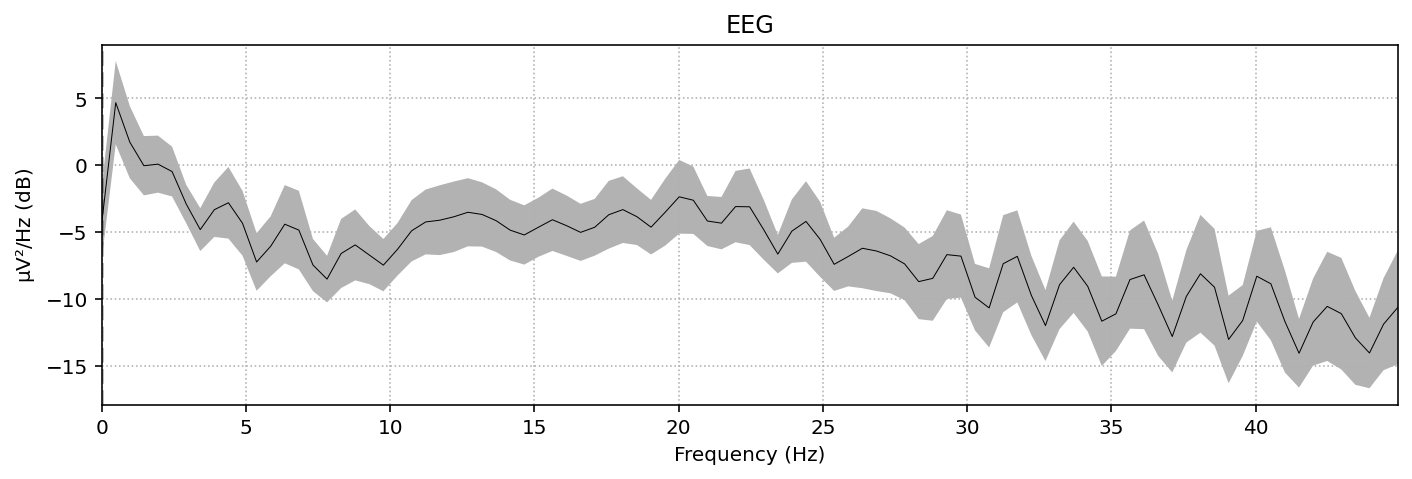

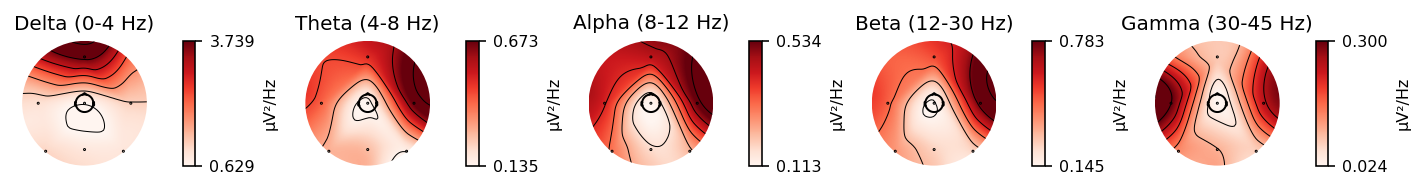

In [8]:
# cut the frequency interval to below 50 Hz
#
spectrum=raw.compute_psd( fmin=0, fmax=45)
_ = spectrum.plot(average=True, )
_ = spectrum.plot_topomap()

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/1577597921.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/1577597921.py:26: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


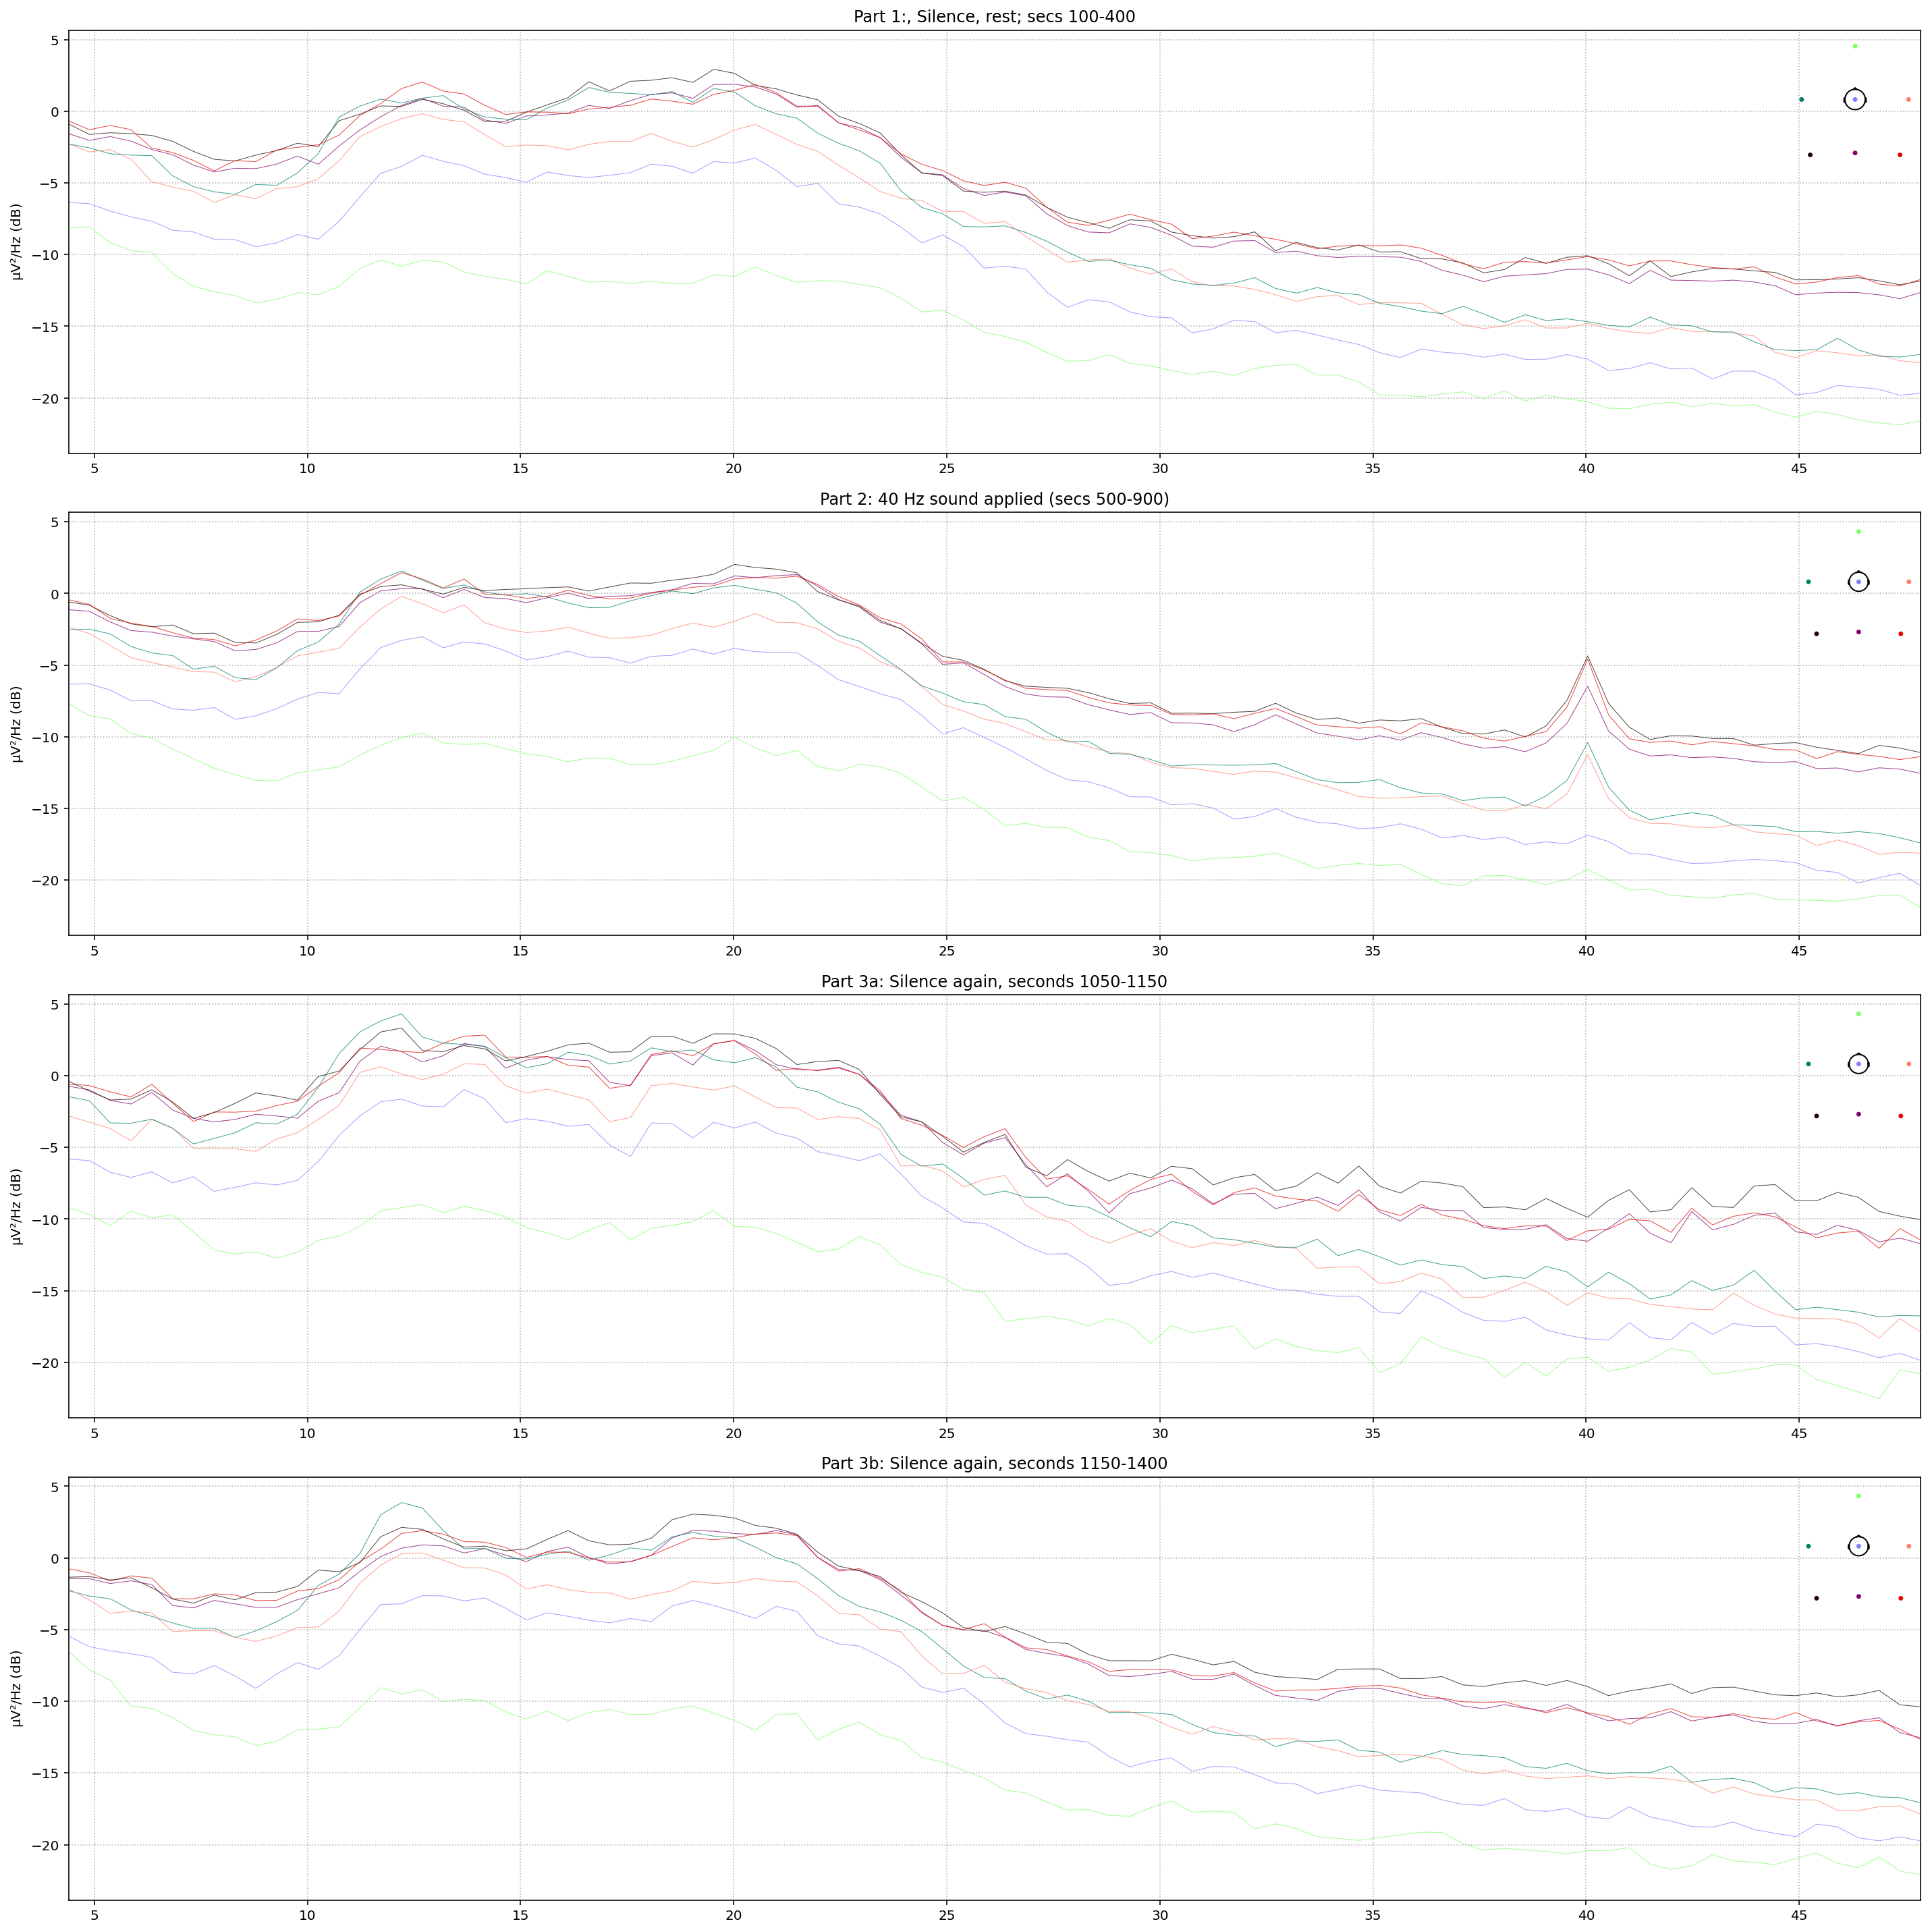

In [8]:
# Repeat the PSD plots, with slightly modified end-period.
# This was intended to see if I could resolve the ending to see if the Gamma excitation lived on a little
# after I turned the sound off, but apparently, if this is the case, the effect is necessarily lost in the
# noise caused by my physical movement.  
#
# And the effect is not as impressive as in the first PSD plot, anyway

fig, ax = plt.subplots(4, sharey=True)  # In this example dataset, we have 3 channel types -> 3 axes required!

fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=100,tmax=400,fmin=4.0,fmax=48.0, ax=ax[0], show=False)
ax[0].set_title('Part 1:, Silence, rest; secs 100-400')

_ = mne.viz.plot_raw_psd(raw,tmin=500,tmax=900,fmin=4.0,fmax=48.0, ax=ax[1], show=False)
ax[1].set_title('Part 2: 40 Hz sound applied (secs 500-900)')

_ = mne.viz.plot_raw_psd(raw,tmin=1050,tmax=1150,fmin=4.0,fmax=48.0, ax=ax[2], show=False)
ax[2].set_title('Part 3a: Silence again, seconds 1050-1150')

_ = mne.viz.plot_raw_psd(raw,tmin=1100,tmax=1400,fmin=4.0,fmax=48.0, ax=ax[3], show=False)
ax[3].set_title('Part 3b: Silence again, seconds 1150-1400')

fig.tight_layout()  
fig.show()

## Time-Frequency
Attempt to show a time-frequency graphic of some sort 

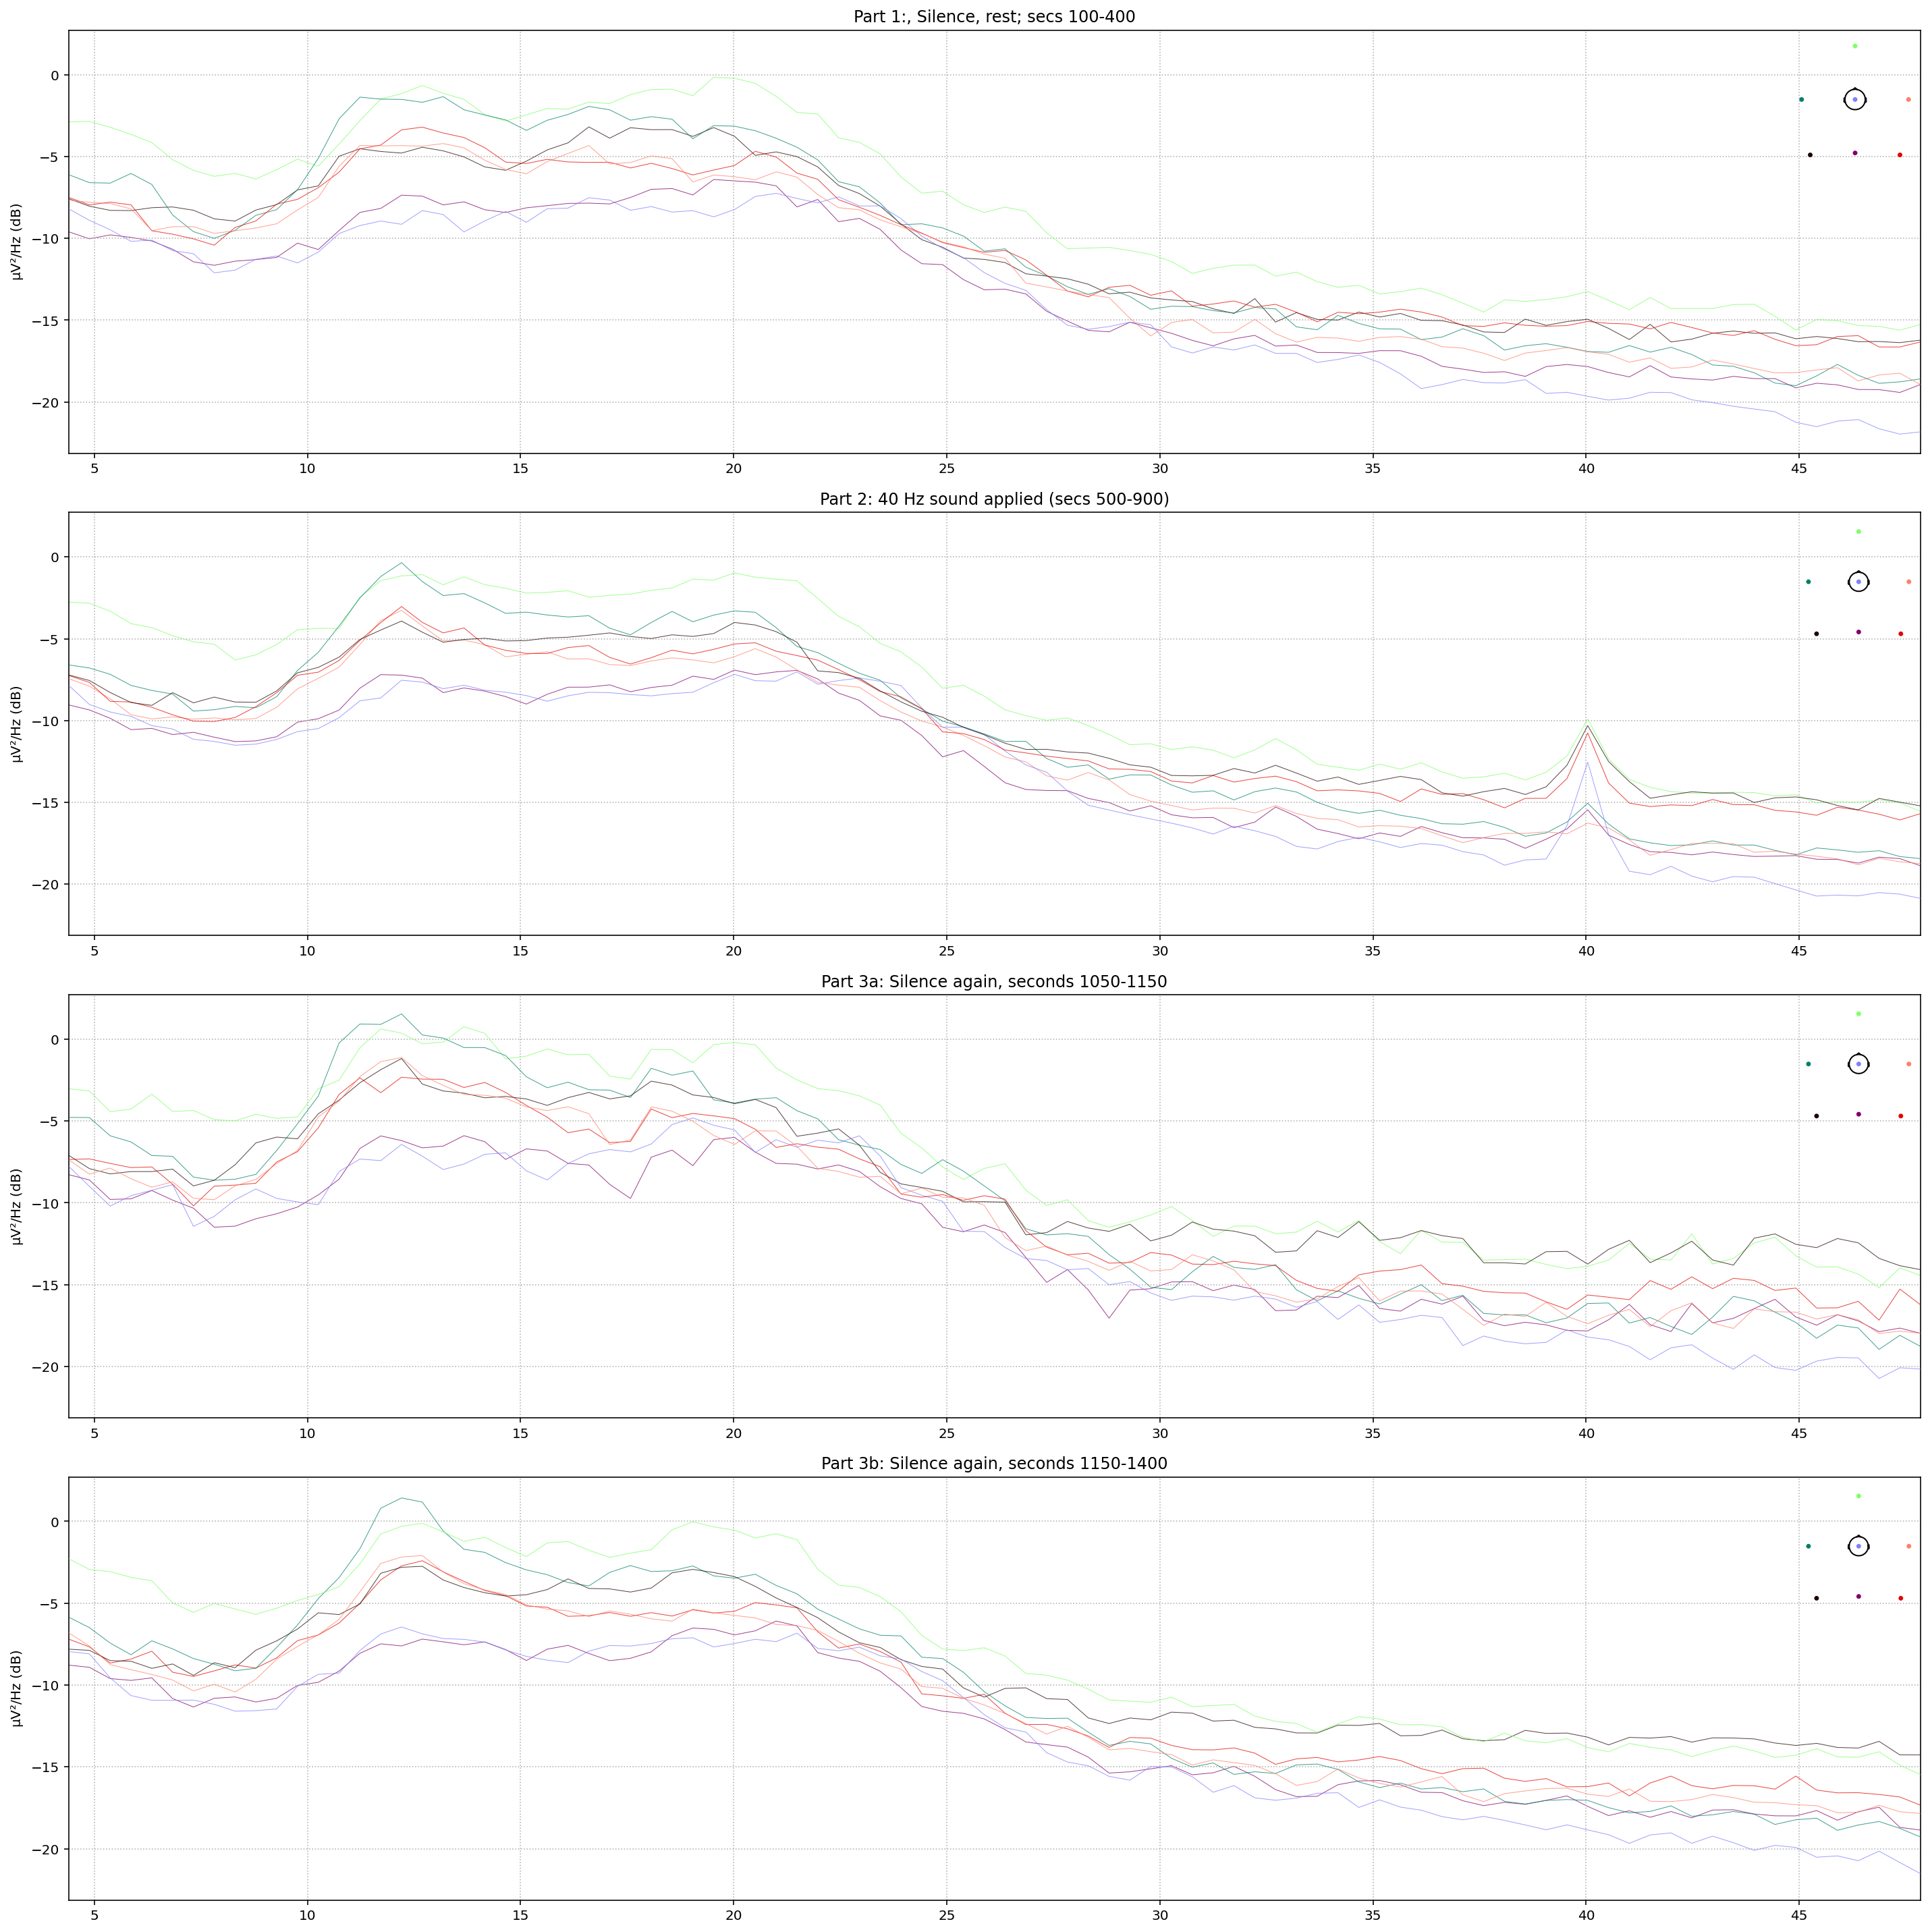

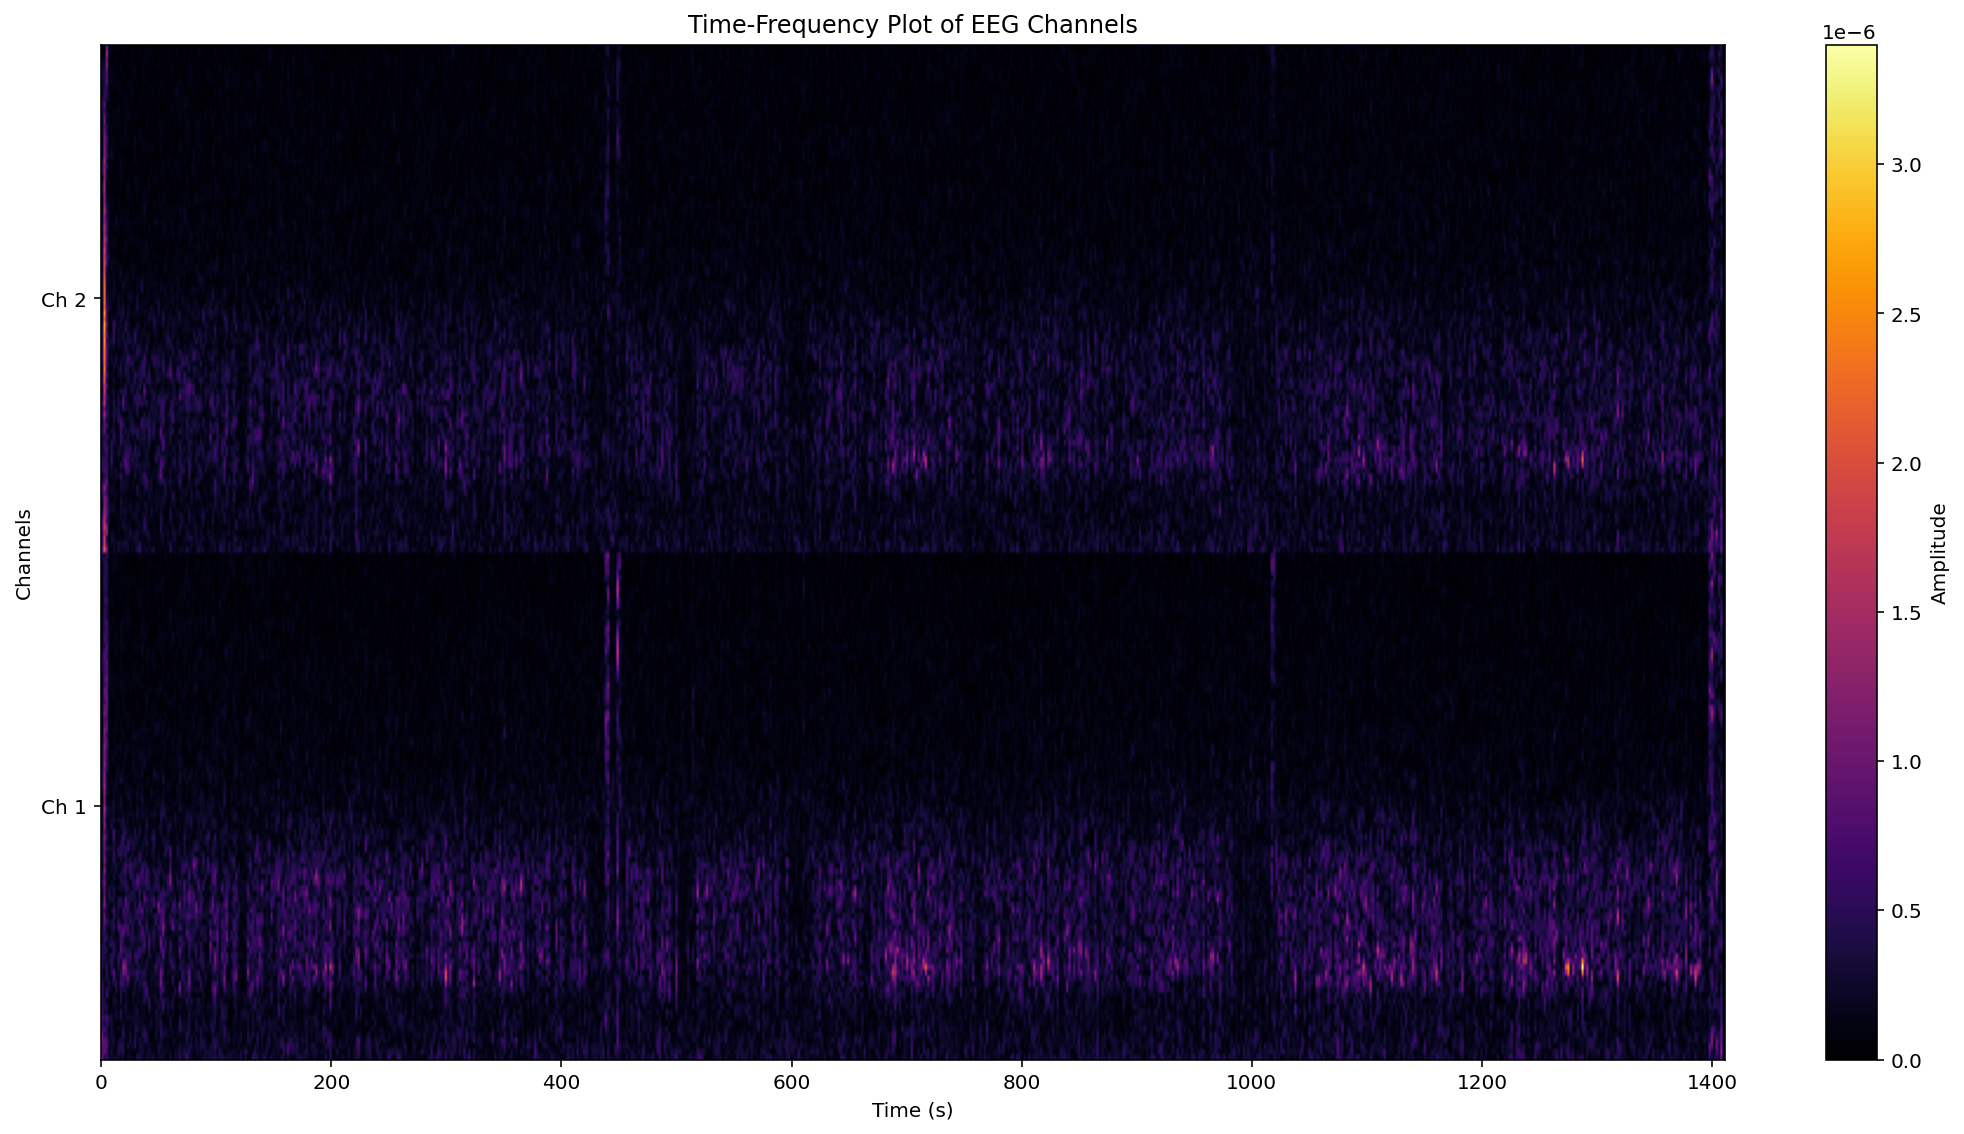

In [10]:
# Attempt to plot a time-frequency image of some sort
#
n_channels = 2
sampling_rate = 1000  # Hz
duration = 1409  # seconds
n_samples = sampling_rate * duration

# Generate random EEG data for demonstration
eeg_data = raw.get_data()

# Define parameters for STFT
frequencies = (4, 48)  # Frequency range in Hz
window = 'hann'        # Window type
nperseg = 2048         # Length of each segment in samples
noverlap =   0         # Overlap between segments

# Initialize a matrix to store the combined time-frequency data
# for plotting all channels in a single image
all_channel_tfr = []

# Compute STFT for each channel and stack results
for i in range(n_channels):
    # Perform STFT
    f, t, Zxx = stft(eeg_data[i], fs=sampling_rate, window=window, nperseg=nperseg, noverlap=noverlap)
    
    # Restrict frequencies to the desired range
    freq_mask = (f >= frequencies[0]) & (f <= frequencies[1])
    f = f[freq_mask]
    Zxx = Zxx[freq_mask, :]
    
    # Append the absolute amplitude of Zxx to the matrix
    all_channel_tfr.append(np.abs(Zxx))

# Convert to a 2D matrix for plotting (combine across channels)
all_channel_tfr = np.vstack(all_channel_tfr)

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))
pcm = ax.imshow(all_channel_tfr, aspect='auto', extent=[t[0], t[-1], 0, n_channels], origin='lower', cmap='inferno')

# Add labels and formatting
ax.set_title('Time-Frequency Plot of EEG Channels')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Channels')
ax.set_yticks(np.arange(n_channels) + 0.5)  # Center tick marks for each channel
ax.set_yticklabels([f'Ch {i+1}' for i in range(n_channels)])
fig.colorbar(pcm, ax=ax, orientation='vertical', label='Amplitude')

plt.tight_layout()
plt.show()


This is somewhat disappointing;

The vertical bands at approximately. 420 and around 1000 seconds, as well as the end around 1400 
is caused by movement when I needed to start/stop  the sound generation 

NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/1793907795.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/1793907795.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


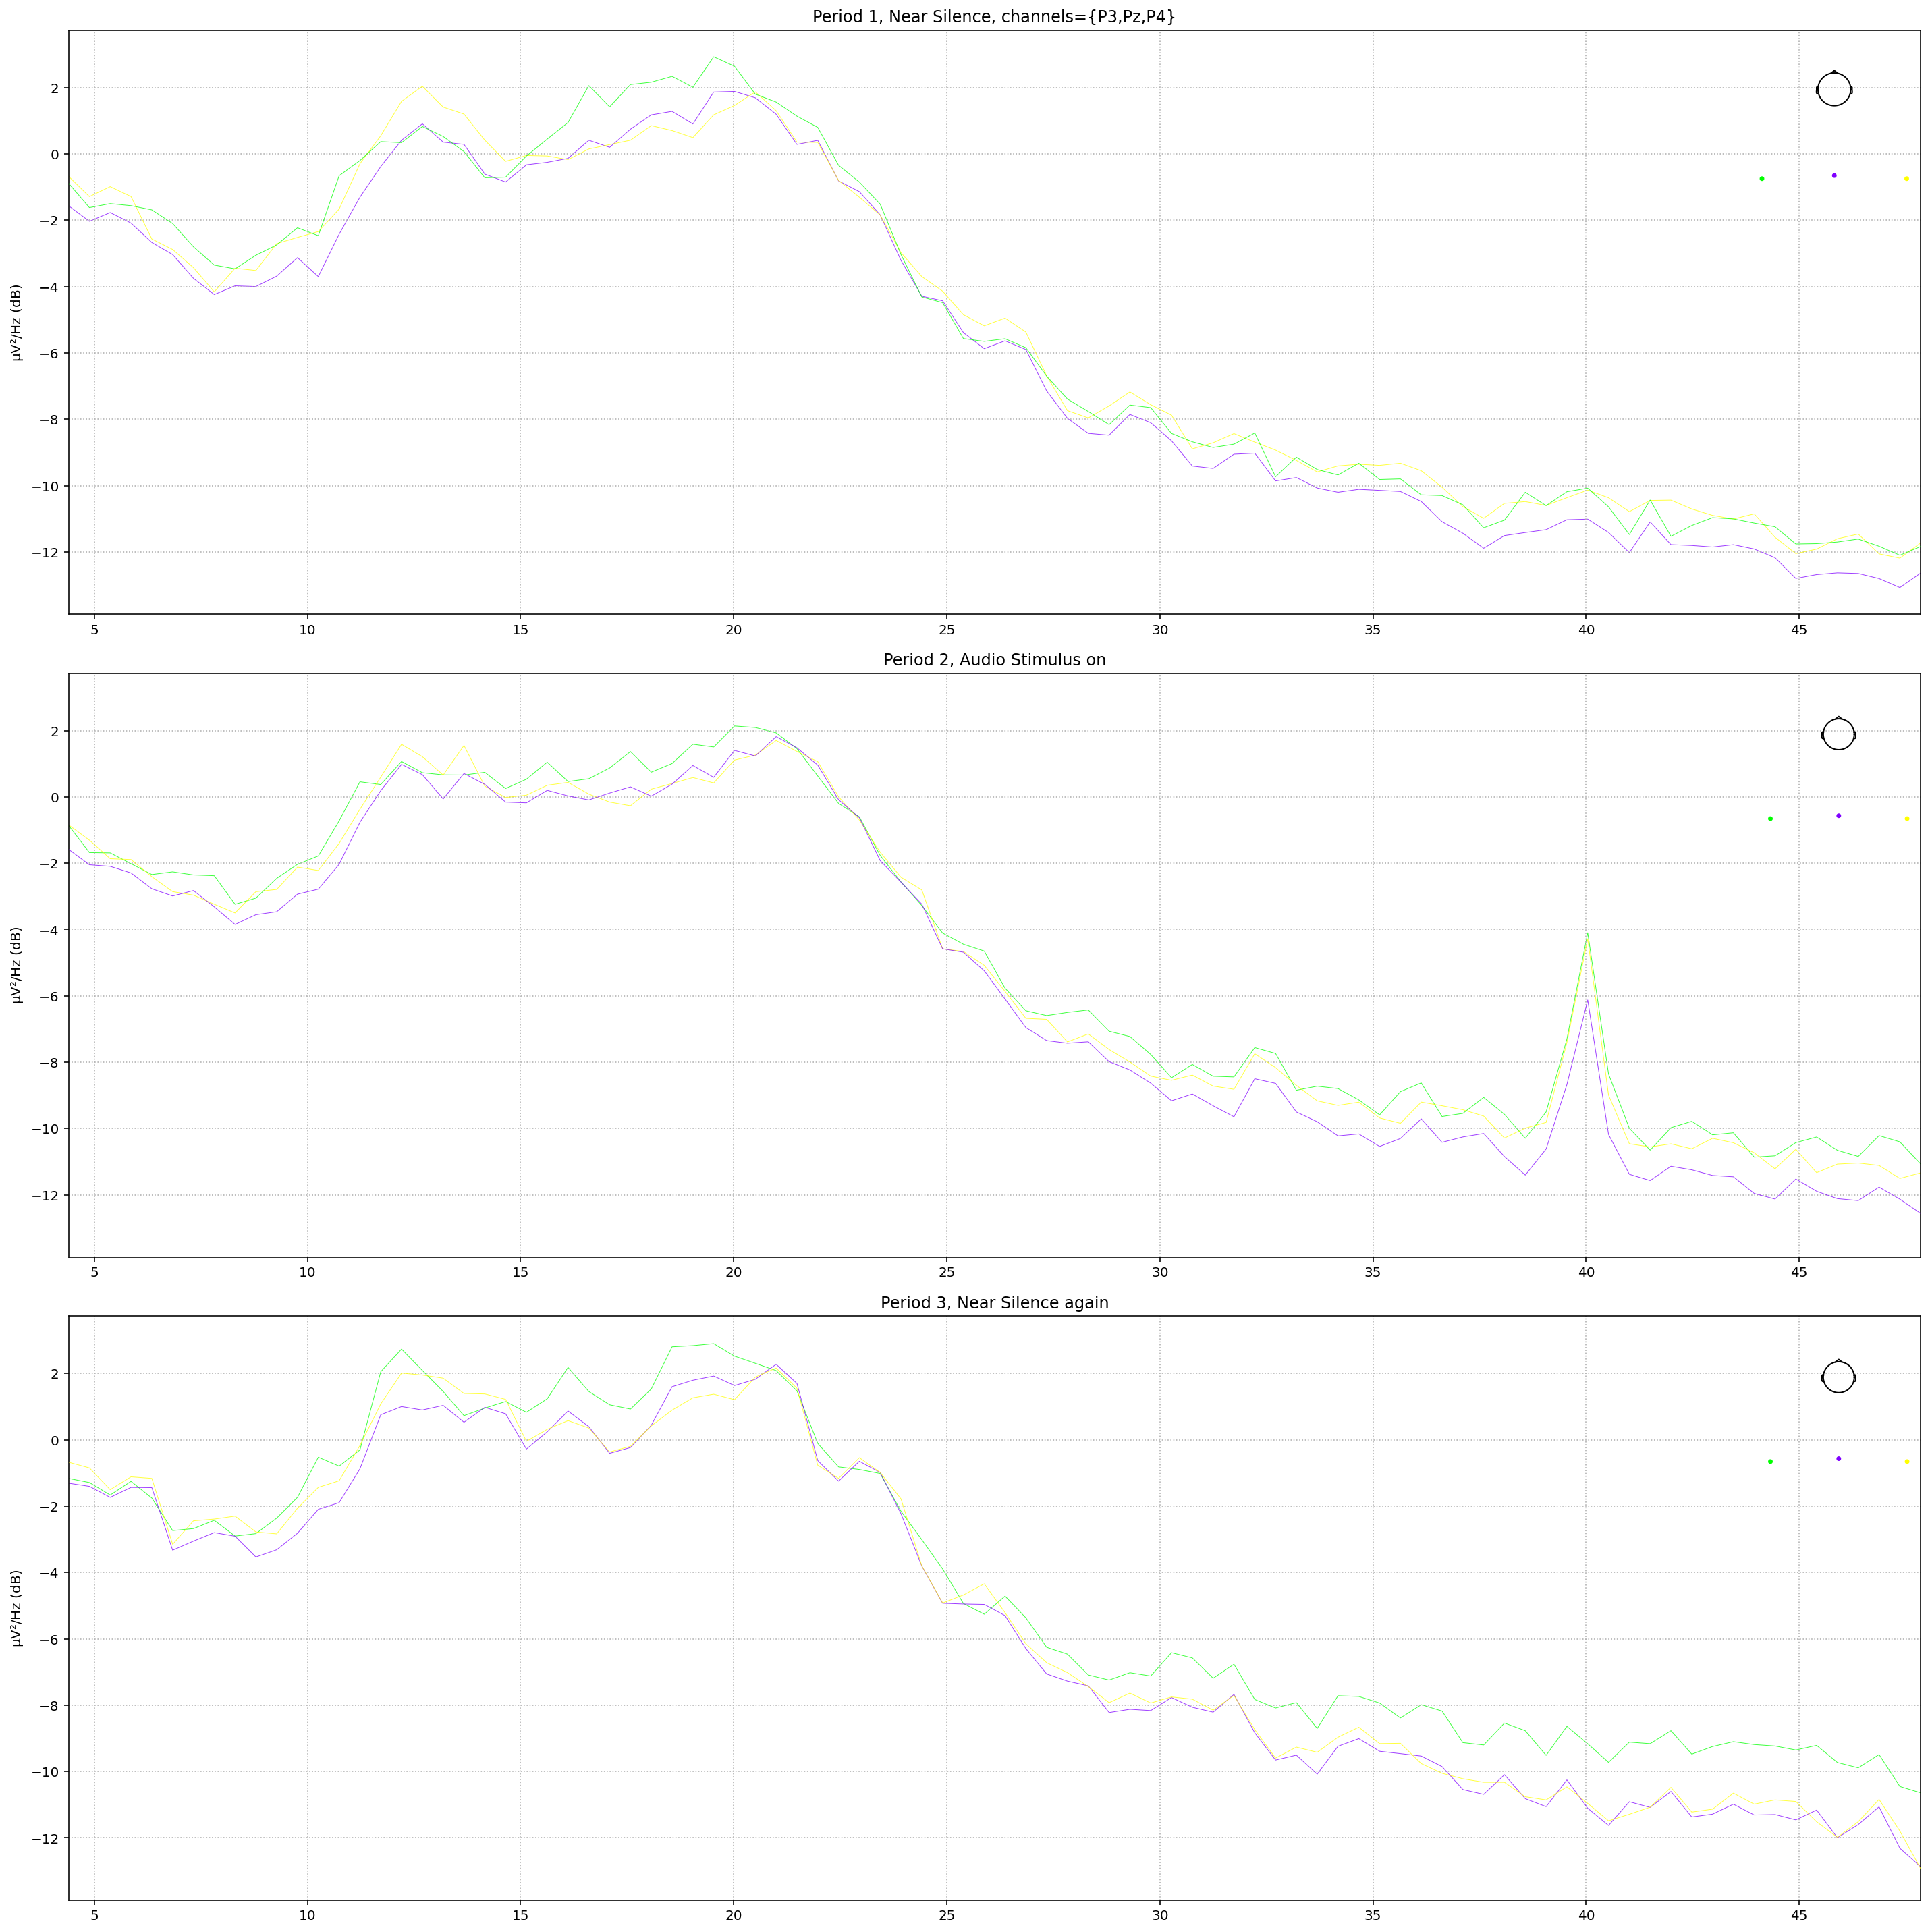

In [9]:
# Parietal lobe -block:
# The effect is quite clear here
#
fig, ax = plt.subplots(3, sharey=True) 

fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=100,tmax=400,fmin=4.0,fmax=48.0,picks=['P3','Pz','P4'], ax=ax[0], show=False)
ax[0].set_title('Period 1, Near Silence, channels={P3,Pz,P4}' )

_ = mne.viz.plot_raw_psd(raw,tmin=600,tmax=900,fmin=4.0,fmax=48.0,picks=['P3','Pz','P4'], ax=ax[1], show=False)
ax[1].set_title('Period 2, Audio Stimulus on')

_ = mne.viz.plot_raw_psd(raw,tmin=1100,tmax=1300,fmin=4.0,fmax=48.0,picks=['P3','Pz','P4'], ax=ax[2], show=False)
ax[2].set_title('Period 3, Near Silence again')


fig.tight_layout()  
fig.show()




NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)
NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


NOTE: plot_raw_psd() is a legacy function. New code should use Raw.compute_psd().plot().
Effective window size : 2.048 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/195238216.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/v5/gtpn5zfx1vq2k73qj46w1kwr0000gn/T/ipykernel_3175/195238216.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


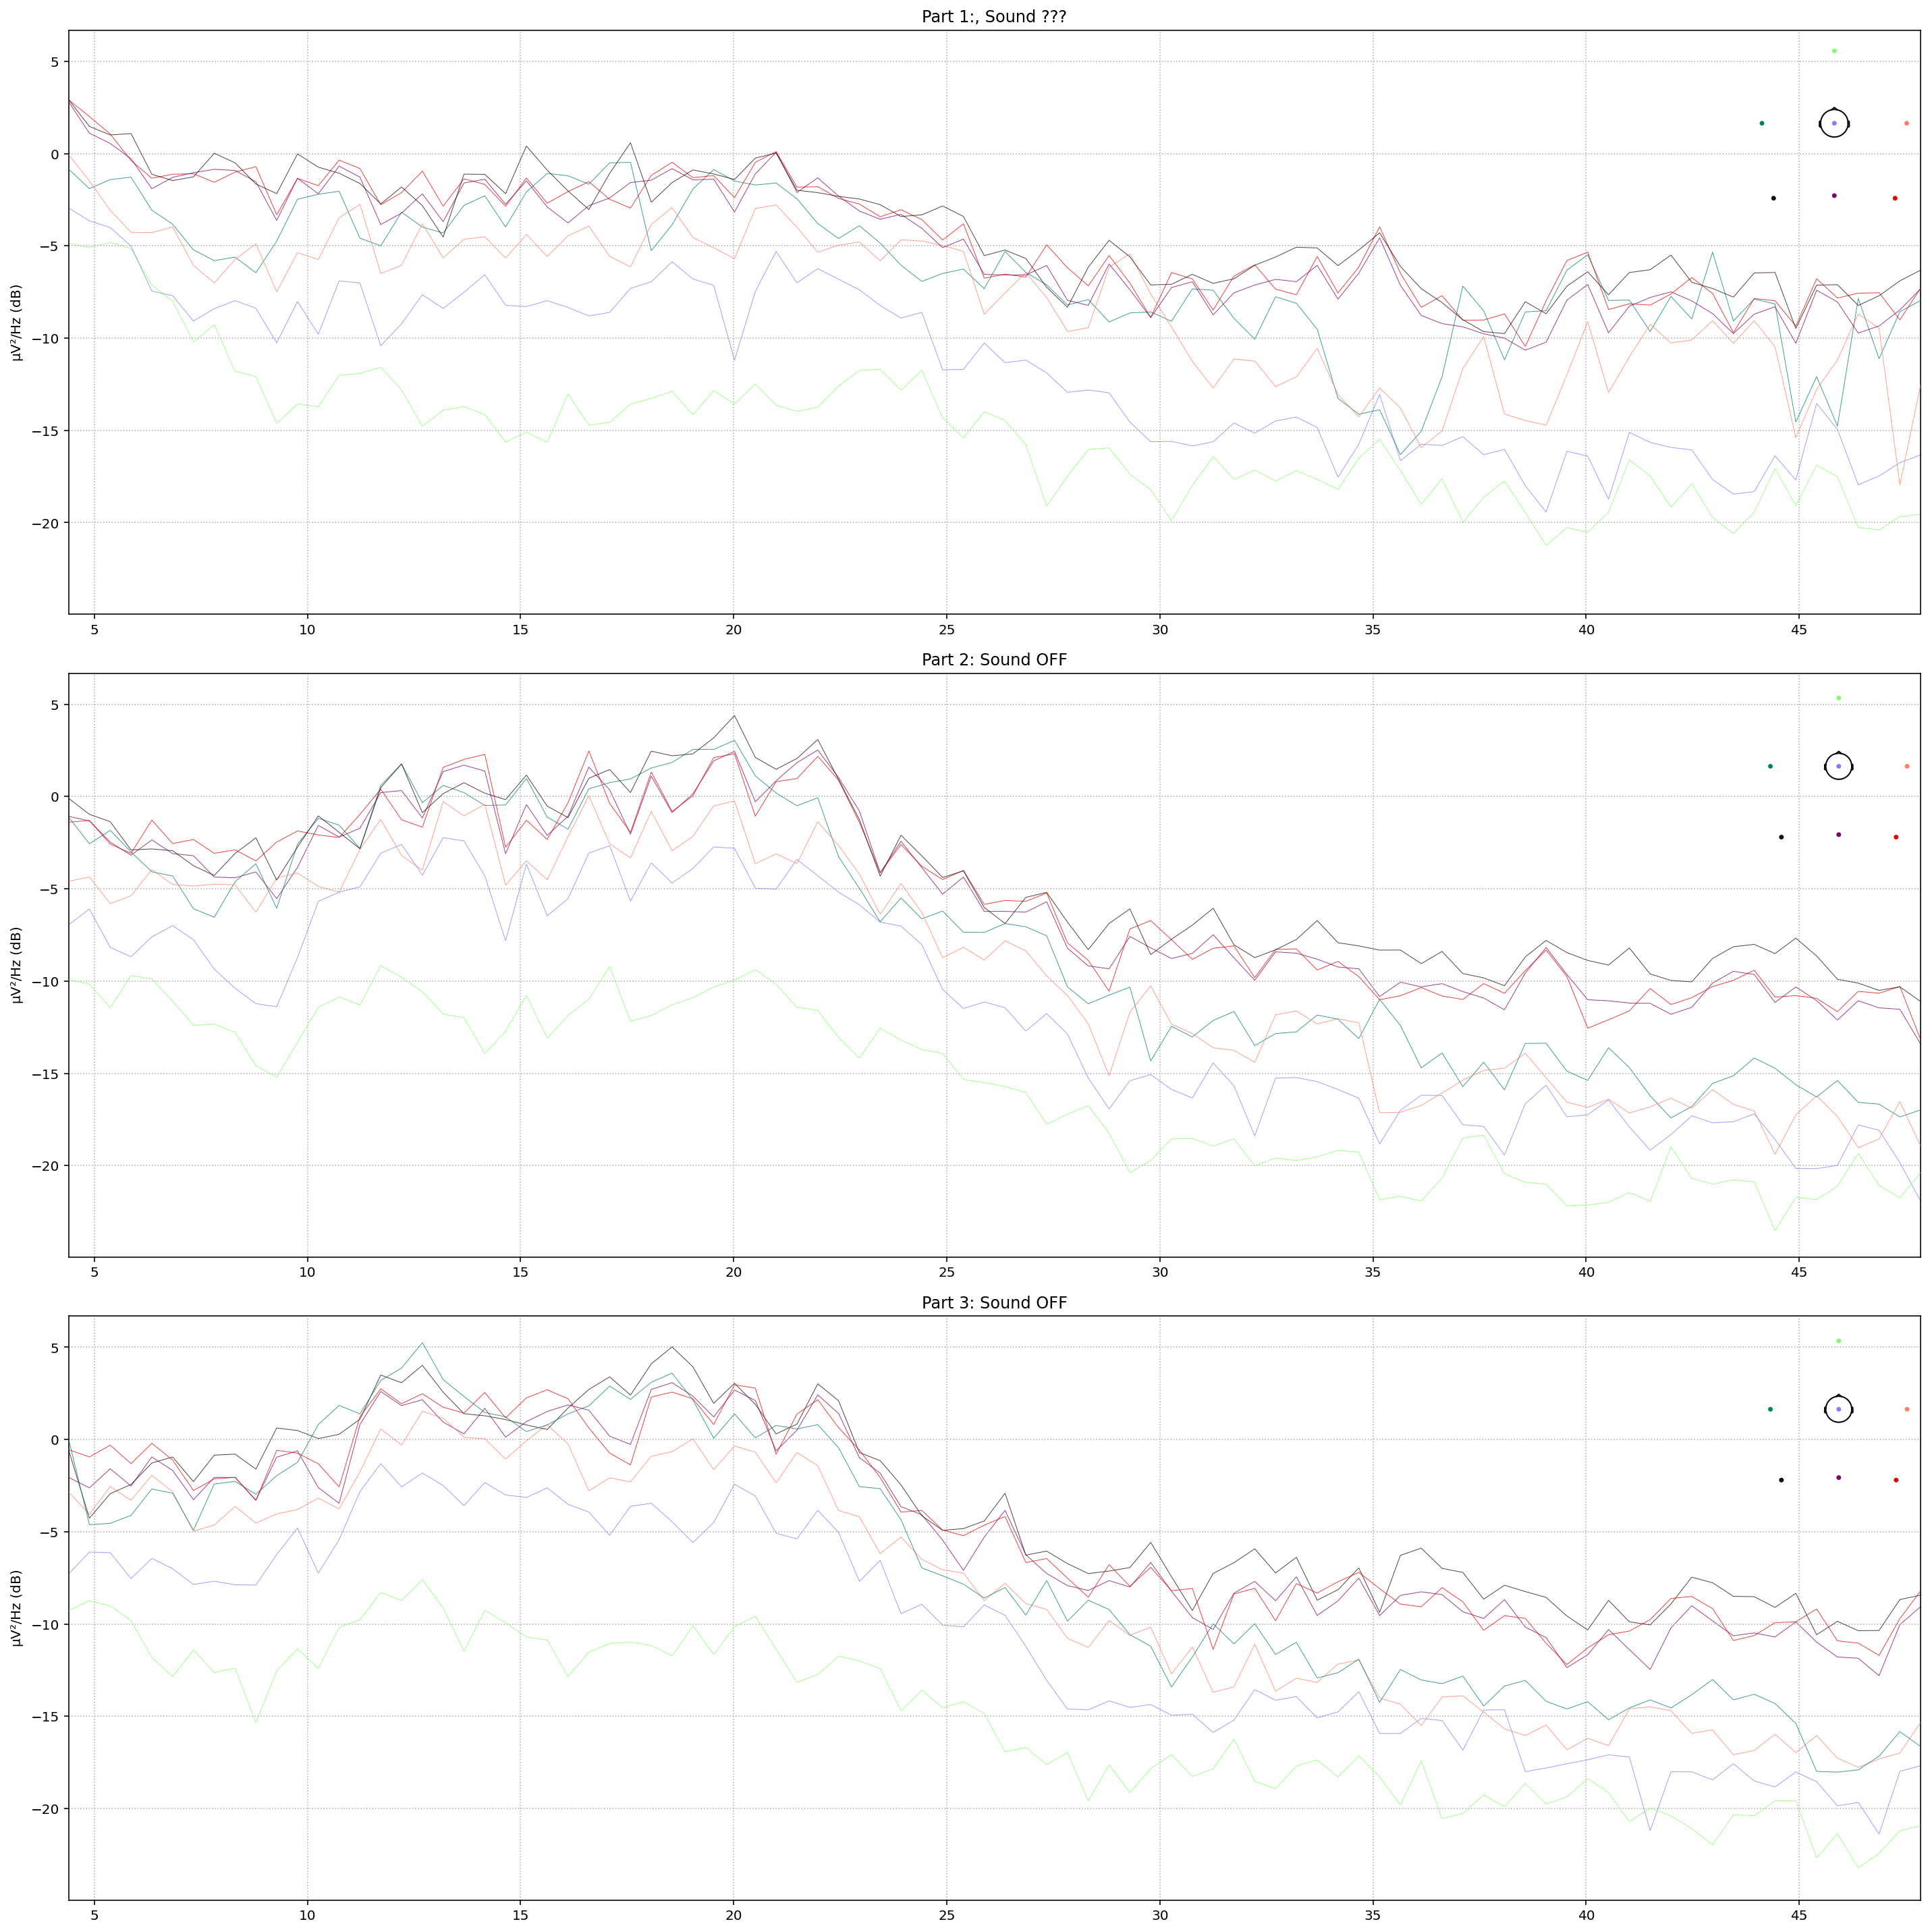

In [10]:
# try to pinpoint where the Gamma effect dies out 
#
# note: -- not as impressive effect --

fig, ax = plt.subplots(3, sharey=True)  # In this example dataset, we have 3 channel types -> 3 axes required!

fig.set_figheight( 20.) 
fig.set_figwidth( 20. )

_ = mne.viz.plot_raw_psd(raw,tmin=1000,tmax=1033,fmin=4.0,fmax=48.0, ax=ax[0], show=False)
ax[0].set_title('Part 1:, Sound ???')

_ = mne.viz.plot_raw_psd(raw,tmin=1034,tmax=1066,fmin=4.0,fmax=48.0, ax=ax[1], show=False)
ax[1].set_title('Part 2: Sound OFF')

_ = mne.viz.plot_raw_psd(raw,tmin=1067,tmax=1100,fmin=4.0,fmax=48.0, ax=ax[2], show=False)
ax[2].set_title('Part 3: Sound OFF')

fig.tight_layout()  
fig.show()

# Conclusion

I need to repeat the experiment, possibly with a few more electrodes, and definitely with an assistant that can start/stop the audio signal (while I remain still)
and can enforce the strict time limits on the three (or N * three) segments of the recording.  It is hard to keep an eye on this without causing some brain activity noise.
